In [86]:
%matplotlib inline

import os

import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

METADATA_DIR = "./fma_metadata/"

In [16]:
def load(filepath):
    """
    Based off code from the fma github
    """
    filename = os.path.basename(filepath)
    if "features" in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])
    if "echonest" in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])
    if "genres" in filename:
        return pd.read_csv(filepath, index_col=0)
    if "tracks" in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [("track", "tags"), ("album", "tags"), ("artist", "tags"),
                   ("track", "genres"), ("track", "genres_all")]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [("track", "date_created"), ("track", "date_recorded"),
                   ("album", "date_created"), ("album", "date_released"),
                   ("artist", "date_created"), ("artist", "active_year_begin"),
                   ("artist", "active_year_end")]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ("small", "medium", "large")
        tracks["set", "subset"] = tracks["set", "subset"].astype(
                "category", categories=SUBSETS, ordered=True)

        COLUMNS = [("track", "genre_top"), ("track", "license"),
                   ("album", "type"), ("album", "information"),
                   ("artist", "bio")]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype("category")

        return tracks

In [108]:
KEYWORDS = [("spectral_centroid", "mean"), ("spectral_centroid", "std"),
            ("chroma_stft", "mean"), ("chroma_stft", "std"),
            ("spectral_rolloff", "mean"), ("spectral_rolloff", "std"),
            ("rmse", "mean"), ("rmse", "std"),
            ("tonnetz", "mean"), ("tonnetz", "std")]

def extract_features(data):
    features = load(METADATA_DIR + "features.csv")

    feature_table = {}
    for composer in data:
        feature_table[composer] = []
        tracks = data[composer]
        for track in tracks:
            track_dict = {}
            tid = track.name
            track_dict["title"] = track["track", "title"]
            for keyword in KEYWORDS:
                try:
                    track_dict[keyword] = features[keyword].loc[[tid]]["01"].item()
                except KeyError:
                    track_dict[feature] = None
                    continue
            feature_table[composer] += [track_dict]
    return feature_table

In [98]:
def load_data(composers_to_learn=None):
    tracks = load(METADATA_DIR + "tracks.csv")
    #genres = load(METADATA_DIR + "genres.csv")

    tracks = tracks[tracks["track", "genre_top"] == "Classical"]
    tracks = tracks[tracks["track", "composer"].notnull()]
    composer_dict = {}
    for index, row in tracks.iterrows():
        composer = row["track", "composer"]
        if composers_to_learn:
            for c in composers_to_learn:
                if c in composer:
                    composer = composers_to_learn[composers_to_learn.index(c)]
        if composers_to_learn and composer not in composers_to_learn:
            continue
        if composer not in composer_dict:
            composer_dict[composer] = [row]
        else:
            composer_dict[composer] += [row]

    return composer_dict

In [71]:
def get_learning_data(data):
    """
    Make data usable by sklearn
    """
    composer_era_map = {"Bach":"Baroque", "Haydn":"Classical",
                        "Alkan":"Romantic", "Orff":"Modern"}
    trimmed_data = {}
    era_counts = {}
    for composer in data:
        era = composer_era_map[composer]
        if era not in era_counts: era_counts[era] = len(data[composer])
        else: era_counts[era] += len(data[composer])

    x = []
    y = []
    num_tracks = min(era_counts.values())
    era_counts = {}
    for composer in data:
        for d in data[composer]:
            era = composer_era_map[composer]
            if era not in era_counts: era_counts[era] = 1
            else: era_counts[era] += 1
            if era_counts[era] > num_tracks: continue
            y.append(composer_era_map[composer])
            vector = []
            for feature in d:
                if feature != "title":
                    vector.append(d[feature])
            x.append(vector)
    return x, y

In [20]:
def count_data(composer_dict):
    count_dict = {}
    for composer in composer_dict:
        count_dict[composer] = len(composer_dict[composer])
    return count_dict

In [21]:
composers_to_learn = ["Bach", "Haydn", "Alkan", "Orff"]
composer_data = load_data(composers_to_learn)
count_dict = count_data(composer_data)
for c in count_dict:
    print(c + ": " + str(count_dict[c]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


Alkan: 25
Orff: 24
Bach: 348
Haydn: 44


In [94]:
features = extract_features(composer_data)

In [95]:
x, y = get_learning_data(features)
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
# print(x)
print(len(x), len(y))

96 96


('spectral_centroid', 'mean') vs. ('spectral_centroid', 'std')


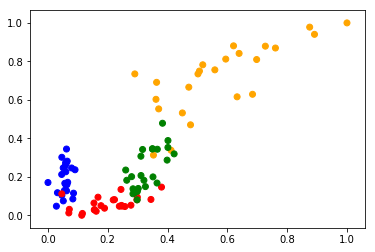


('spectral_centroid', 'std') vs. ('spectral_centroid', 'mean')


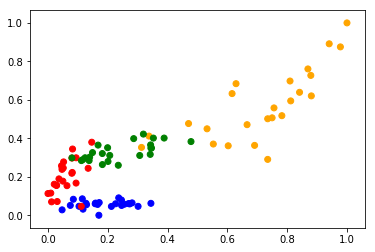

In [97]:
# DATA VISUALIZATION
single_feature_vectors = [[] for _ in range(len(x[0]))]
color_map = {"Baroque":"red", "Classical":"green",
            "Romantic":"blue", "Modern":"orange"}
colors = []
for k, data_pt in enumerate(x):
    colors.append(color_map[y[k]])
    for i in range(len(data_pt)):
        single_feature_vectors[i].append(data_pt[i])
for a in range(2):
    for b in range(2):
        if a != b:
            print(KEYWORDS[a], "vs.", KEYWORDS[b])
            plt.scatter(single_feature_vectors[a], single_feature_vectors[b], c=colors)
            plt.show()
            print()

In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [111]:
bach_features = extract_features({"Bach":composer_data["Bach"]})
bach_x, bach_y = get_learning_data(bach_features)

1. visualize
 - PCA to reduce dimention - use scipy
 -scatter plot of features
 -to visualize the data 
 -to see performance of the classifier
2. AdaBoost
3. Random Forrest